# PREPROCESS

In [ ]:
from PIL import Image
from glob import glob
from tqdm import tqdm
import os

In [ ]:
OUTPUT_SIZE = (512, 340)
OUTPUT_DIR = '../input/images_res/'

In [ ]:
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

In [ ]:
pathes = glob('../input/images/*.jpg')

In [ ]:
for path in tqdm(pathes):
    image = Image.open(path)
    if image.height > image.width:
        image = image.transpose(Image.ROTATE_90)
    image = image.resize(OUTPUT_SIZE, Image.BICUBIC)
    image.save(OUTPUT_DIR + os.path.basename(path))

In [ ]:
img = Image.open(pathes[0])
img.resize([512, 340], PIL.Image.BICUBIC)

# CREATE FOLDS

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold

In [ ]:
FEATURES = 'image_id'

In [ ]:
df = pd.read_csv('../input/train.csv')
df['kfold'] = np.nan
df = df.sample(frac=1).reset_index(drop=True)

X = df[FEATURES].values
y = df.iloc[:, 2] + df.iloc[:, 3] * 2 + df.iloc[:, 4] * 3

In [ ]:
y.value_counts()

In [ ]:
skf = StratifiedKFold(n_splits=5, random_state=42)
for fold, (train, valid) in enumerate(skf.split(X, y)):
    df.loc[valid, 'kfold'] = fold

print(df['kfold'].value_counts(dropna=False))

In [ ]:
print(df.head())

# DATASET

In [1]:
DIR_INPUT = '../input'
# OUTPUT_SIZE = (512, 340)

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
class PlantDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms=transforms
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        image_src = DIR_INPUT + '/images_res/' + self.df.loc[idx, 'image_id'] + '.jpg'
        image = cv2.imread(image_src, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        labels = self.df.loc[idx, ['healthy', 'multiple_diseases', 'rust', 'scab']].values
        labels = torch.from_numpy(labels.astype(np.int8))
        labels = labels.unsqueeze(-1)
        
        if self.transforms:
            transformed = self.transforms(image=image)
            image = transformed['image']

        return image, labels

In [4]:
transforms_train = A.Compose([
#     A.RandomResizedCrop(height=SIZE, width=SIZE, p=1.0),
    A.Flip(p=0.5),
#     A.Mirr
    A.ShiftScaleRotate(rotate_limit=1.0, p=0.8),

    # Pixels
    A.OneOf([
        A.IAAEmboss(p=1.0),
        A.IAASharpen(p=1.0),
        A.Blur(p=1.0),
    ], p=0.5),

    # Affine
    A.OneOf([
        A.ElasticTransform(p=1.0),
        A.IAAPiecewiseAffine(p=1.0)
    ], p=0.5),

    A.Normalize(p=1.0),
    ToTensorV2(p=1.0),
])

transforms_valid = A.Compose([
#     A.Resize(height=SIZE, width=SIZE, p=1.0),
    A.Normalize(p=1.0),
    ToTensorV2(p=1.0),
])

In [5]:
import pandas as pd

In [6]:
train_df = pd.read_csv(DIR_INPUT + '/train.csv')
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [17]:
dataset = PlantDataset(train_df)

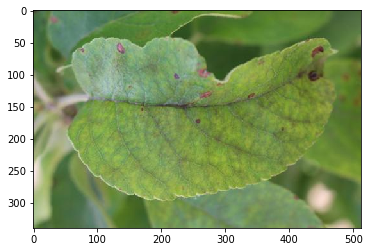

In [18]:
import matplotlib.pyplot as plt
plt.imshow(dataset[25][0])

In [19]:
from dataset import PlantDataset

In [20]:
dataset = PlantDataset(train_df)

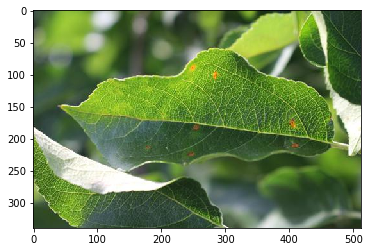

In [21]:
import matplotlib.pyplot as plt
plt.imshow(dataset[35][0])